In [1]:
import scipy.io
import numpy as np
import sciann as sn

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.4 
Python Version: 3.8.18 (default, Sep 11 2023, 13:40:15) 
[GCC 11.2.0] 



In [2]:
def PrepareData(num_data=5000, random=True):
    data = scipy.io.loadmat('cylinder_nektar_wake.mat')

    U_star = data['U_star']
    P_star = data['p_star']
    t_star = data['t']
    X_star = data['X_star']

    N = X_star.shape[0]
    T = t_star.shape[0]

    ##重新排列数据
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T

    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star  # N x T

    ##选取随机数据
    if random:
        idx = np.random.choice(N * T, num_data, replace=False)
    else:
        idx = np.arange(0, N * T)

    x = XX.flatten()[idx, None]  # NT x 1
    y = YY.flatten()[idx, None]  # NT x 1
    t = TT.flatten()[idx, None]  # NT x 1

    u = UU.flatten()[idx, None]  # NT x 1
    v = VV.flatten()[idx, None]  # NT x 1
    p = PP.flatten()[idx, None]  # NT x 1

    return (x, y, t, u, v, p)

In [3]:
x_train, y_train, t_train, u_train, v_train, p_train = PrepareData(5000, random=True)

In [4]:
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

P = sn.Functional("P", [x, y, t], 8*[20], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], 8*[20], 'tanh')

In [5]:
lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")

In [6]:
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

In [7]:
##数据
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P)

##NS方程
c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))

##连续性方程
c3 = sn.Data(u_x + v_y)

c4 = Psi*0.0

In [8]:
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[d1, d2, d3, c1, c2, c3, c4],
    loss_func="mse",
    plot_to_file='NS-Model.png'
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
##input
input_data = [x_train, y_train, t_train]

##target
data_d1 = u_train
data_d2 = v_train
data_d3 = p_train
data_c1 = 'zeros'
data_c2 = 'zeros'
data_c3 = 'zeros'
data_c4 = 'zeros'
target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

##训练
history = model.train(
    x_true=input_data,
    y_true=target_data,
    epochs=10000,
    batch_size=100,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
)

model.save_weights('trained-navier-stokes.hdf5')


Total samples: 5000 
Batch size: 5000 
Total batches: 1 



2024-07-26 11:47:36.186335: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 11:47:41.875149: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-26 11:47:41.875212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22162 MB memory:  -> device: 0, name: B1.gpu.large, pci bus id: 0000:39:00.0, compute capability: 8.6


Epoch 1/100
1/1 [==============================] - 28s 28s/step - batch: 0.0000e+00 - size: 5000.0000 - loss: 0.9443 - Grad__loss: 0.7577 - mul_loss: 0.0788 - P_loss: 0.0575 - sub_2_loss: 0.0256 - sub_4_loss: 0.0248 - add_7_loss: 2.6763e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 28.3912
Epoch 2/100
1/1 [==============================] - 2s 2s/step - batch: 0.0000e+00 - size: 5000.0000 - loss: 0.8854 - Grad__loss: 0.7634 - mul_loss: 0.0773 - P_loss: 0.0220 - sub_2_loss: 0.0136 - sub_4_loss: 0.0091 - add_7_loss: 1.9736e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 2.0057
Epoch 3/100
1/1 [==============================] - 2s 2s/step - batch: 0.0000e+00 - size: 5000.0000 - loss: 0.8717 - Grad__loss: 0.7617 - mul_loss: 0.0769 - P_loss: 0.0130 - sub_2_loss: 0.0121 - sub_4_loss: 0.0081 - add_7_loss: 1.9506e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 1.9910
Epoch 4/100
1/1 [==============================] - 2s 2s/step - batch: 0.0000e+00 - size: 5000.0000 - loss: 0.8735 - G

In [10]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))

lambda1: [0.28351739],  lambda2: [0.87735609]


Text(0, 0.5, 'loss')

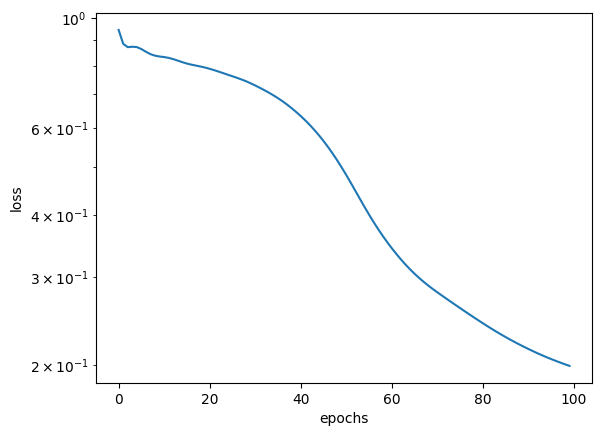

In [12]:
import matplotlib.pyplot as plt

plt.semilogy(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')